# ソルバを使う
`scipy`，`control`ライブラリを使って設計する方法を説明する．  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.linalg import expm
import control

## システムを定義

<img src="https://latex.codecogs.com/png.image?\dpi{120}&space;\bg_white&space;\dot{x}&space;=&space;Ax&space;&plus;&space;Bu,~~y&space;=&space;Cx\\~~~~~x,&space;u\in\mathbb{R}^{2},~A,B,C\in\mathbb{R}^{2\times&space;2}" title="\bg_white \dot{x} = Ax + Bu,~~y = Cx\\~~~~~x, u\in\mathbb{R}^{2},~A,B,C\in\mathbb{R}^{2\times 2}" />

In [2]:
x0 = np.array([[1, 0.5]]).T
A = np.array([
    [1.1, 2],
    [-0.3, -1],
])
B = np.array([
    [1, 2],
    [0.847, 3],
])
C = np.eye(2)

安定性を調べる

In [3]:
w, _ = np.linalg.eig(A)
w

array([ 0.75887234, -0.65887234])

固有値に正のものがあるのでこのシステムは不安定．  
初期値応答を調べる．  

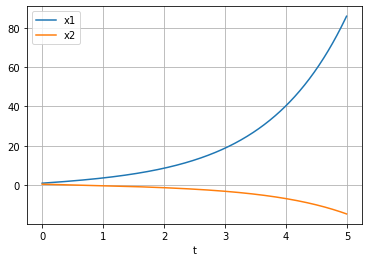

In [4]:
t = np.arange(0, 5, 0.01)
x = np.concatenate([y @ x0 for y in [expm(A*s) for s in t]], axis=1)
plt.plot(t, x[0, :], label="x1")
plt.plot(t, x[1, :], label="x2")
plt.xlabel("t")
plt.legend()
plt.grid()

発散することがわかる．  

****
## scipy
`sipy.linalg`の行列方程式ソルバで連続時間代数リカッチ方程式を解く．  
公式ページ : [https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_continuous_are.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_continuous_are.html)  

次の連続時間リカっち方程式を解く．  
$$
PA+A^{\top}P-PBR^{-1}B^{\top}X+Q=0
$$

```python
solve_continuous_are(A, B, Q, R)
```
* `A` : $A$行列  
* `B` : $B$行列  
* `Q` : 状態変数に対する重み行列$Q$  
* `R` : 入力に対する重み行列$R$  

※離散時間の場合は`solve_discreate_are`

In [5]:
Q = np.diag([10, 10])
R = np.diag([1, 1])
Ps = sp.linalg.solve_continuous_are(A, B, Q, R)
Ps  # リカッチ方程式の解

array([[ 3.34568216, -1.07265801],
       [-1.07265801,  1.30235279]])

In [6]:
Fs = np.linalg.inv(R) @ B.T @ Ps  # 最適フィードバック行列
As_new = A - B @ Fs  # 最適レギュレータ

固有値を調べる  

In [7]:
w_new, _ = np.linalg.eig(As_new)
w_new

array([-11.86244676,  -2.73247999])

全て負で安定化されていることがわかる．  
時間発展を調べる．  

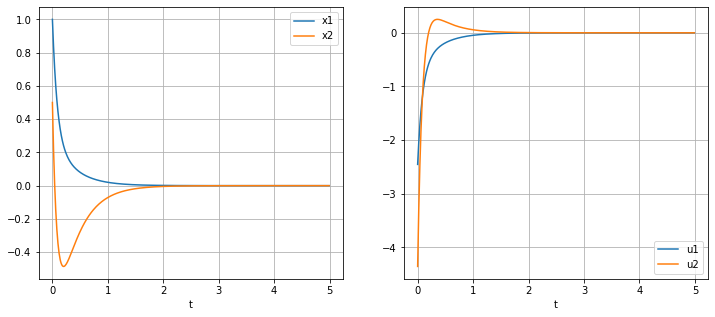

In [8]:
x2 = [y @ x0 for y in [expm(As_new*s) for s in t]]
x2_ = np.concatenate(x2, axis=1)
u2 = np.concatenate([-Fs @ y for y in x2], axis=1)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(t, x2_[0, :], label="x1")
ax[0].plot(t, x2_[1, :], label="x2")
ax[1].plot(t, u2[0, :], label="u1")
ax[1].plot(t, u2[1, :], label="u2")
for ax_ in ax:
    ax_.set_xlabel("t")
    ax_.legend()
    ax_.grid()

****
# Python-Contorol
まずはシステムを定義

In [9]:
sys = control.ss(A, B, C, np.zeros_like(B))

初期値応答を調べる．次の関数を使う．  

```python
initial_response(sys, T, x0)
```
* `sys` : システム  
* `T` : 終了時間  
* `x0` : 初期値

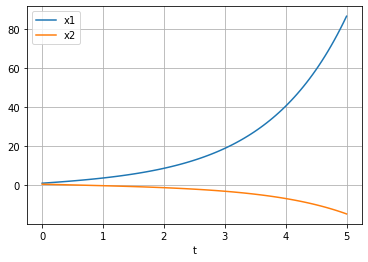

In [10]:
resp = control.initial_response(sys, 5, x0)
plt.plot(resp.t, resp.x[0,:], label="x1")
plt.plot(resp.t, resp.x[1,:], label="x2")
plt.legend()
plt.xlabel("t")
plt.grid()

`control.lqr`を使ってリカッチ方程式を解く．  
公式ページ : [https://python-control.readthedocs.io/en/0.9.1/generated/control.lqr.html#control.lqr](https://python-control.readthedocs.io/en/0.9.1/generated/control.lqr.html#control.lqr)

```python
control.lqr(sys, Q, R)
```
戻り値は
* `K` : 最適フィードバック行列
* `P` : リカッチ方程式の解
* `E` : Kを使用した閉ループの固有値

In [11]:
K, Pc, E = control.lqr(sys, Q, R)
Pc

array([[ 3.34568216, -1.07265801],
       [-1.07265801,  1.30235279]])

In [12]:
E

array([-11.862447+0.j,  -2.73248 +0.j], dtype=complex64)

A行列を更新し初期値応答を調べる．  

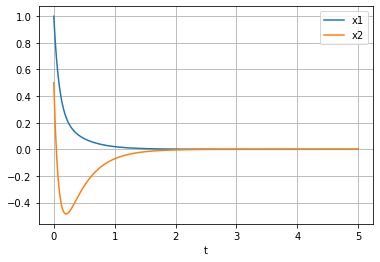

In [13]:
sys.A = sys.A - B @ K
resp2 = control.initial_response(sys, 5, x0)
plt.plot(resp2.t, resp2.x[0,:], label="x1")
plt.plot(resp2.t, resp2.x[1,:], label="x2")
plt.legend()
plt.xlabel("t")
plt.grid()

****
両ソルバの解の比較

In [14]:
Ps - Pc

array([[-3.10862447e-15,  1.77635684e-15],
       [ 1.77635684e-15, -1.55431223e-15]])

出されたリカッチ方程式の解はほぼ同じ．  
ただし実行速度はscipyのほうが倍程度早い．  